<a href="https://colab.research.google.com/github/SrijithBalachander/HTR_CRNN_CTC/blob/main/Handwritten_text_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Text Recognition using CNN-BiLSTM

## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


## Downloading IAM Dataset - Aachen Partition

In [2]:
!wget https://raw.githubusercontent.com/omni-us/research-seq2seq-HTR/master/RWTH_partition/RWTH.iam_word_gt_final.test.thresh
!wget https://raw.githubusercontent.com/omni-us/research-seq2seq-HTR/master/RWTH_partition/RWTH.iam_word_gt_final.train.thresh
!wget https://raw.githubusercontent.com/omni-us/research-seq2seq-HTR/master/RWTH_partition/RWTH.iam_word_gt_final.valid.thresh

--2022-05-25 00:09:13--  https://raw.githubusercontent.com/omni-us/research-seq2seq-HTR/master/RWTH_partition/RWTH.iam_word_gt_final.test.thresh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469090 (458K) [text/plain]
Saving to: ‘RWTH.iam_word_gt_final.test.thresh’

RWTH.iam_word_gt_fi 100%[===================>] 458.10K  --.-KB/s    in 0.02s   

2022-05-25 00:09:13 (20.0 MB/s) - ‘RWTH.iam_word_gt_final.test.thresh’ saved [469090/469090]

--2022-05-25 00:09:13--  https://raw.githubusercontent.com/omni-us/research-seq2seq-HTR/master/RWTH_partition/RWTH.iam_word_gt_final.train.thresh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserc

In [3]:
!cp "/content/drive/MyDrive/IAM_dataset/words.tgz"  /content/


In [4]:
!mkdir words/
!tar -xzf "/content/words.tgz" -C words/

## Preprocessing Input Data and Labels

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [6]:
import os
import cv2
import re

In [7]:
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [8]:
char_encoding = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_len_label = 0

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_encoding.index(char))
        except:
            print(char)
        
    return dig_lst

In [35]:
valid_path = []
valid_label = []
valid_label_enc = []
valid_input_len = []
valid_label_len = []

with open("/content/RWTH.iam_word_gt_final.valid.thresh") as valid_list:
  for value in valid_list:
    valid_path.append(value.split(",")[0].strip()+".png")
    label = value.split(" ",1)[1].strip()
    valid_label.append(label)
    valid_label_enc.append(encode_to_labels(label))
    valid_label_len.append(len(label))
    valid_input_len.append(31)

print(valid_path[:5])

max_len_label = max(max_len_label,len(max(valid_label, key=len)))
# print(max_len_label)

['n02-000-00-00.png', 'n02-000-00-01.png', 'n02-000-00-02.png', 'n02-000-00-03.png', 'n02-000-00-04.png']


In [36]:
train_path = []
train_label = []
train_label_enc = []
train_input_len = []
train_label_len = []

with open("/content/RWTH.iam_word_gt_final.train.thresh") as train_list:
  for value in train_list:
    train_path.append(value.split(",")[0].strip()+".png")
    label = value.split(" ",1)[1].strip()
    train_label.append(label)
    train_label_enc.append(encode_to_labels(label))
    train_label_len.append(len(label))
    train_input_len.append(31)

print(train_label[:5])

max_len_label = max(max_len_label,len(max(train_label, key=len)))
# print(max_len_label)

['are', 'many', 'reasons', '.', 'Wood']


In [37]:
test_path = []
test_label = []
with open("/content/RWTH.iam_word_gt_final.test.thresh") as test_list:
  for value in test_list:
    test_path.append(value.split(",")[0].strip()+".png")
    test_label.append(value.split(" ",1)[1].strip())

# print(test_path)

max_len_label = max(max_len_label,len(max(test_label, key=len)))
# print(max_len_label)

In [38]:
print(max_len_label)

21


In [12]:
train_padded_txt = pad_sequences(train_label_enc, maxlen=max_len_label, padding='post', value = len(char_encoding))
valid_padded_txt = pad_sequences(valid_label_enc, maxlen=max_len_label, padding='post', value = len(char_encoding))

In [13]:
train_img = []
valid_img = []
test_img = []
all_paths = {}

for root, dirs, files in os.walk("words/"):
  for file in files:
    all_paths[file]=os.path.join(root, file)


for file in train_path:
  if file in all_paths:
    input_img = cv2.cvtColor(cv2.imread(all_paths[file]),cv2.COLOR_BGR2GRAY)
    # input_img = cv2.imread(all_paths[file])
    # print(input_img.shape, type(input_img))
    # print(input_img)
    input_img = cv2.resize(input_img, (128,32))
    # print(input_img.shape)
    # print(input_img)
    input_img = np.expand_dims(input_img, axis=2)
    # input_img = cv2.resize(input_img, (128,32))
    # print(input_img.shape)
    input_img = input_img/255
    # print(input_img)
    train_img.append(input_img)

for file in valid_path:
  if file in all_paths:
    input_img = cv2.cvtColor(cv2.imread(all_paths[file]),cv2.COLOR_BGR2GRAY)
    input_img = cv2.resize(input_img, (128,32))
    input_img = np.expand_dims(input_img, axis=2)
    input_img = input_img/255
    valid_img.append(input_img)

for file in test_path:
  if file in all_paths:
    input_img = cv2.cvtColor(cv2.imread(all_paths[file]),cv2.COLOR_BGR2GRAY)
    input_img = cv2.resize(input_img, (128,32))
    input_img = np.expand_dims(input_img, axis=2)
    input_img = input_img/255
    test_img.append(input_img)

  # elif file in valid_path:
  #   valid_img.append(cv2.imread(os.path.join(root, file)))

  # elif file in test_path:
  #   test_img.append(cv2.imread(os.path.join(root, file)))

print(test_img[0].shape)
print(len(train_img), len(test_img), len(valid_img))

(32, 128, 1)
47981 20305 7554


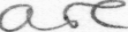

are


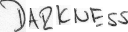

DARKNESS


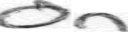

on


In [14]:
from google.colab.patches import cv2_imshow
cv2_imshow(train_img[0]*255)
print(train_label[0])

cv2_imshow(valid_img[0]*255)
print(valid_label[0])

cv2_imshow(test_img[0]*255)
print(test_label[0])

## Network Architecture

Based on [this](https://arxiv.org/pdf/1507.05717.pdf) paper and [this](https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-1/) blog.

In [15]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_encoding)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [16]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [17]:
labels = Input(name='the_labels', shape=[max_len_label], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [18]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [19]:
training_img = np.array(train_img)
train_input_length = np.array(train_input_len)
train_label_length = np.array(train_label_len)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_len)
valid_label_length = np.array(valid_label_len)

In [20]:
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(train_label_len)), batch_size=256, epochs = 10, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_input_len))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/10
188/188 [==============================] - ETA: 0s - loss: 15.5817
Epoch 1: val_loss improved from inf to 18.80876, saving model to best_model.hdf5
188/188 [==============================] - 98s 404ms/step - loss: 15.5817 - val_loss: 18.8088
Epoch 2/10
188/188 [==============================] - ETA: 0s - loss: 12.5838
Epoch 2: val_loss did not improve from 18.80876
188/188 [==============================] - 66s 350ms/step - loss: 12.5838 - val_loss: 27.6343
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 10.7442
Epoch 3: val_loss did not improve from 18.80876
188/188 [==============================] - 66s 354ms/step - loss: 10.7442 - val_loss: 25.0131
Epoch 4/10
188/188 [==============================] - ETA: 0s - loss: 9.1673
Epoch 4: val_loss improved from 18.80876 to 16.41804, saving model to best_model.hdf5
188/188 [==============================] - 67s 356ms/step - loss: 9.1673 - val_loss: 16.4180
Epoch 5/10
188/188 [==============================]

In [30]:
test_img = np.array(test_img)
# test_input_length = np.array(test_input_len)
# test_label_length = np.array(test_label_len)

In [ ]:
# load the saved best model weights
act_model.load_weights('best_model.hdf5')

# predict outputs on validation images
prediction = act_model.predict(test_img)

# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

predicted_labels = ["".join([char_encoding[x] for x in img if x != -1]) for img in out]
# print(["".join([char_encoding[x] for x in img if x != -1]) for img in out])
# print(predicted_labels[:10])

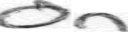

on
on


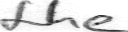

the
the


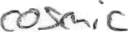

cosmic
cosaric


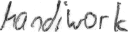

handiwork
handivork


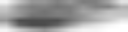

.
,


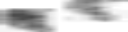

'
"


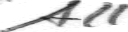

All
Al


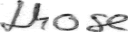

those
those


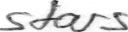

stars
stars


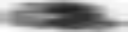

.
.


In [33]:
for i in range(10):
  cv2_imshow(test_img[i]*255)
  print(test_label[i])
  print(predicted_labels[i])

In [ ]:
drive.flush_and_unmount()